# EE379K Lab 7

## Irfan Hasan, Peter Zhang

# Question 1

## Part 0

fit a model for the dataset from https://www.kaggle.com/c/GiveMeSomeCredit/data

In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns

from sklearn import metrics, preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline

Data dictionary<br>
<ul>
<li><b>SeriousDlqin2yrs:</b> Person experienced 90 days past due delinquency or worse
<li><b>RevolvingUtilizationOfUnsecuredLines:</b> Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits
<li><b>age:</b> Age of borrower in years
<li><b>NumberOfTime30-59DaysPastDueNotWorse:</b> Number of times borrower has been 30-59 days past due but no worse in the last 2 years.
<li><b>DebtRatio:</b> Monthly debt payments, alimony,living costs divided by monthy gross income
<li><b>MonthlyIncome:</b> Monthly income
<li><b>NumberOfOpenCreditLinesAndLoans:</b> Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards)
<li><b>NumberOfTimes90DaysLate:</b> Number of times borrower has been 90 days or more past due.
<li><b>NumberRealEstateLoansOrLines:</b> Number of mortgage and real estate loans including home equity lines of credit
<li><b>NumberOfTime60-89DaysPastDueNotWorse:</b> Number of times borrower has been 60-89 days past due but no worse in the last 2 years.
<li><b>NumberOfDependents:</b> Number of dependents in family excluding themselves (spouse, children etc.)
</ul>

In [149]:
# read in data
train = pd.read_csv("cs-training.csv")
test = pd.read_csv("cs-test.csv")

# drop id
train = train.drop('Unnamed: 0', axis=1)
test = test.drop('Unnamed: 0', axis=1)

# fill missing values with 0
train = train.fillna(0)
test = test.fillna(0)

# setup training, testing, and final data
test = test.drop('SeriousDlqin2yrs', axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    train.drop('SeriousDlqin2yrs', axis=1),
    train['SeriousDlqin2yrs'],
    test_size=0.15
)

# log transform data
test = np.log1p(test)
X_train = np.log1p(X_train)
X_test = np.log1p(X_test)

In [4]:
X_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
RevolvingUtilizationOfUnsecuredLines,127500.0,0.258415,0.385907,0.0,0.029639,0.143577,0.445503,10.833859
age,127500.0,3.934662,0.293154,0.0,3.737670,3.970292,4.158883,4.700480
NumberOfTime30-59DaysPastDueNotWorse,127500.0,0.147452,0.392636,0.0,0.000000,0.000000,0.000000,4.595120
DebtRatio,127500.0,1.526248,2.628246,0.0,0.161201,0.312168,0.625499,12.696011
MonthlyIncome,127500.0,6.740457,3.561179,0.0,7.332369,8.376551,8.909370,14.917036
NumberOfOpenCreditLinesAndLoans,127500.0,2.087353,0.598534,0.0,1.791759,2.197225,2.484907,4.060443
NumberOfTimes90DaysLate,127500.0,0.057331,0.293497,0.0,0.000000,0.000000,0.000000,4.595120
NumberRealEstateLoansOrLines,127500.0,0.573541,0.499633,0.0,0.000000,0.693147,1.098612,3.496508
NumberOfTime60-89DaysPastDueNotWorse,127500.0,0.048065,0.265967,0.0,0.000000,0.000000,0.000000,4.595120
NumberOfDependents,127500.0,0.394666,0.527868,0.0,0.000000,0.000000,0.693147,3.044522


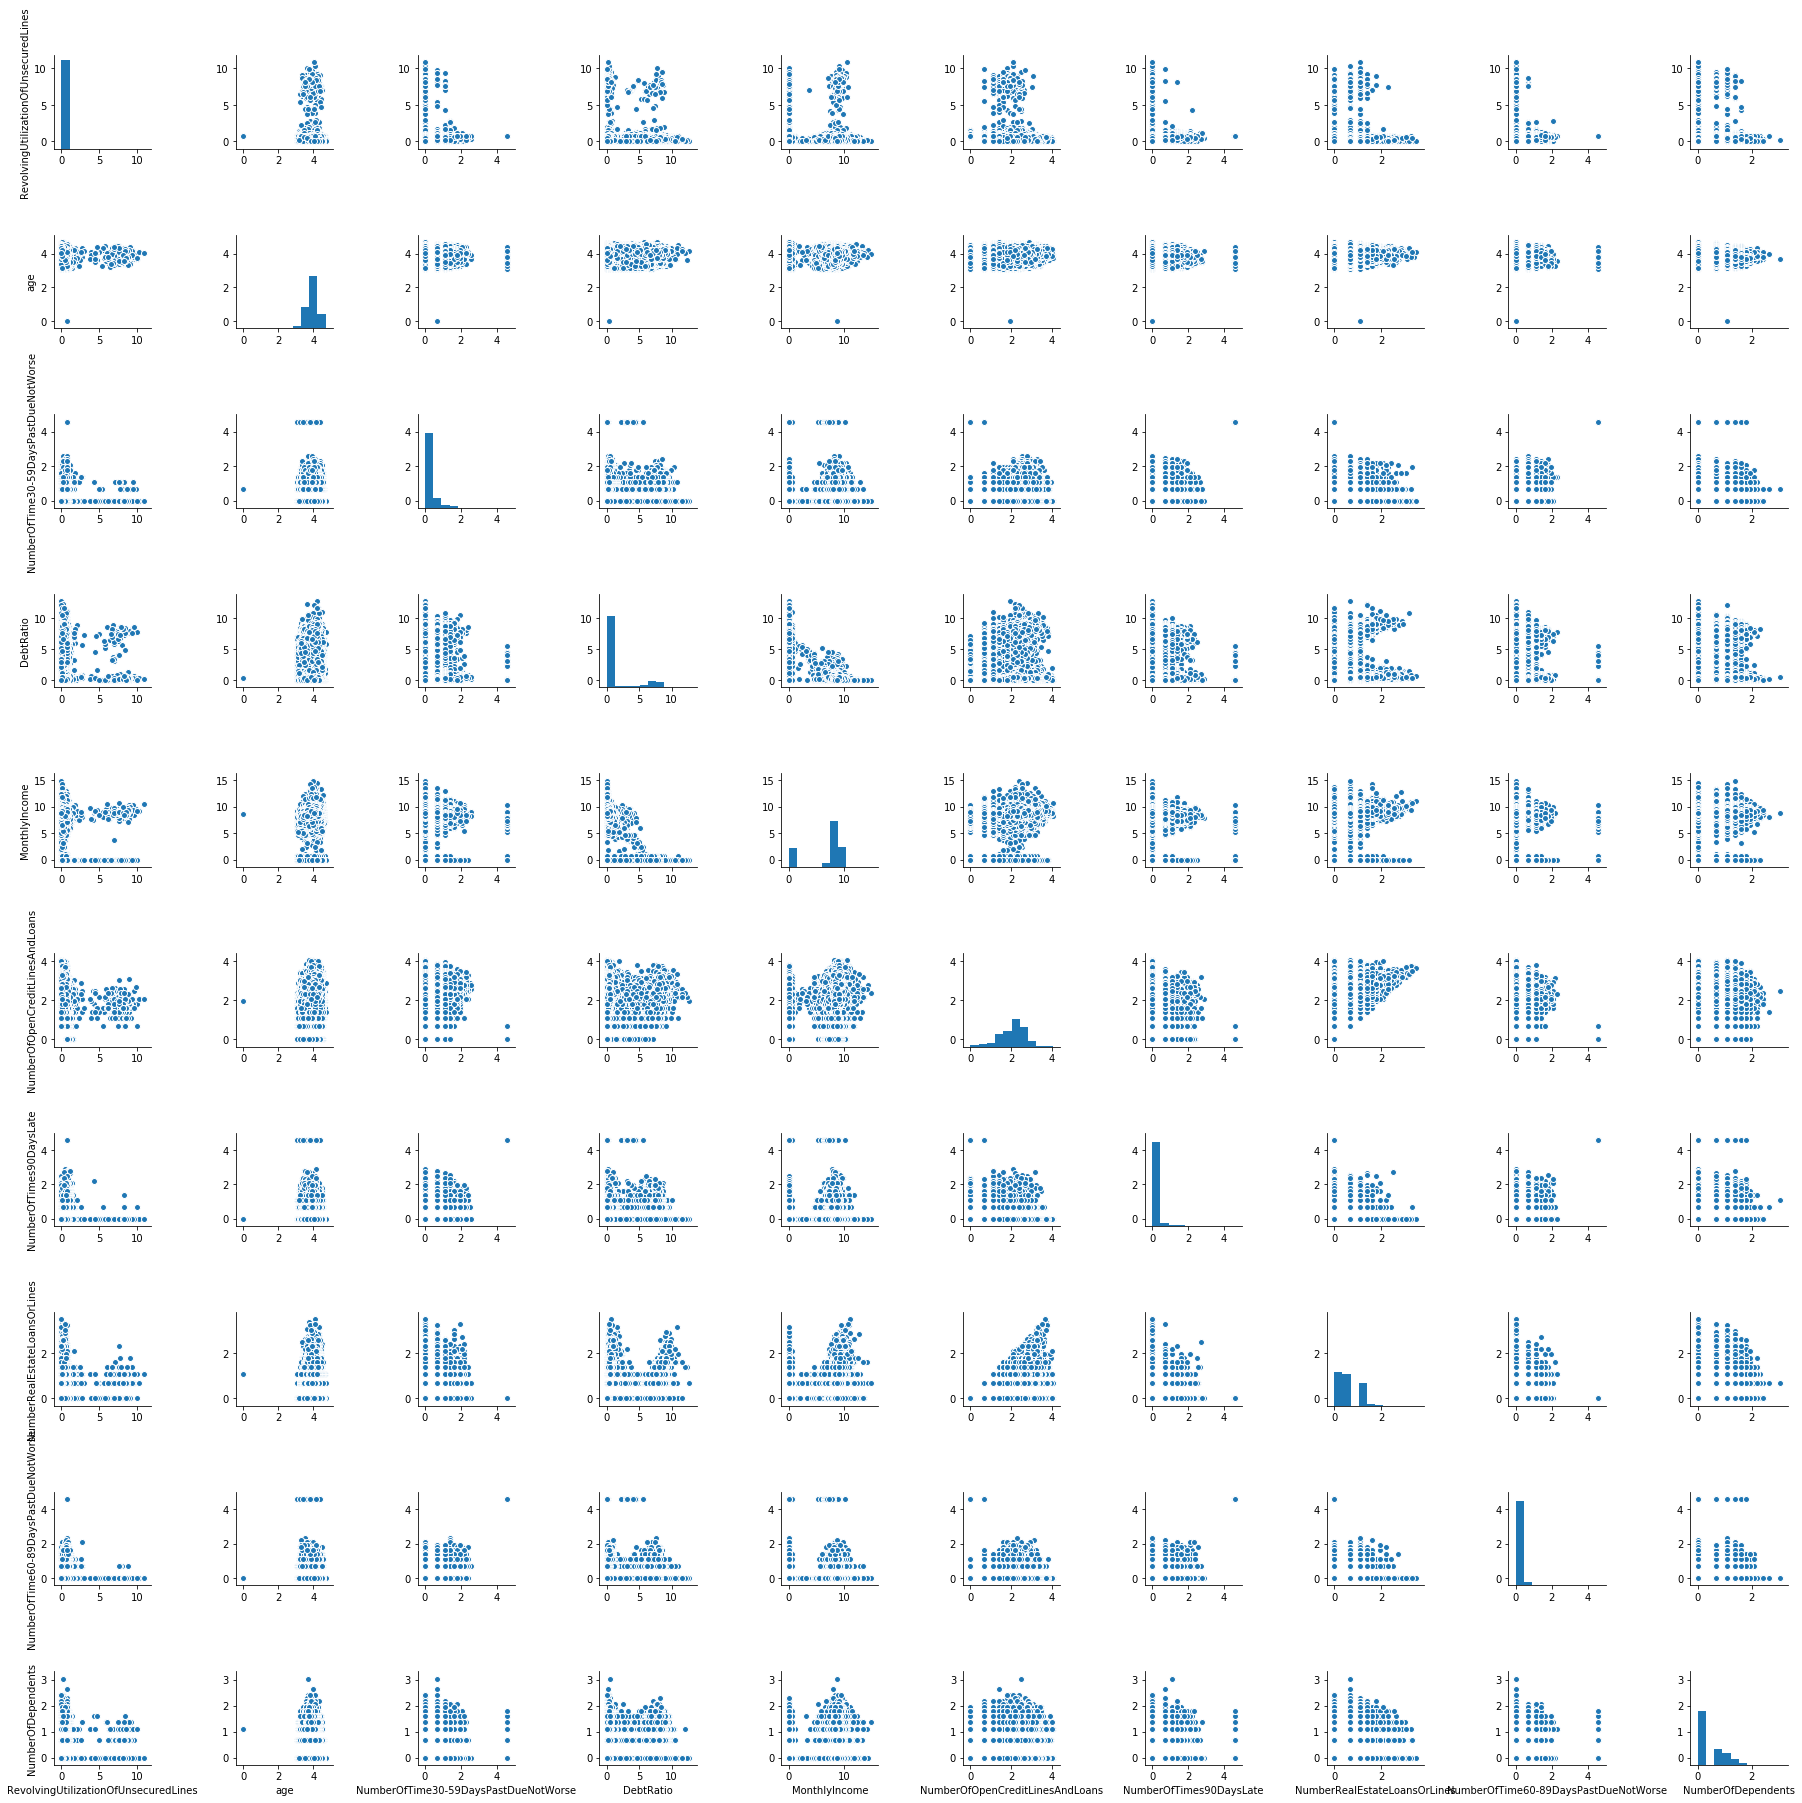

In [5]:
sns.pairplot(X_train)

In [13]:
def modelfit(alg, X_train, y_train, X_test, y_test):
    xgb_param = alg.get_xgb_params()
    xgtrain = xgb.DMatrix(X_train.values, label=y_train.values)
    cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=5,
        metrics='auc', early_stopping_rounds=50)
    alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X_train, y_train, eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(X_test)
    dtrain_predprob = alg.predict_proba(X_test)[:,1]
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(y_test.values, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(y_test, dtrain_predprob)
    
    xgb.plot_importance(alg)
    plt.show()


Model Report
Accuracy : 0.9378
AUC Score (Train): 0.860208


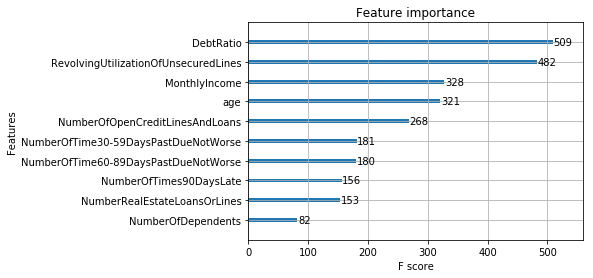

In [7]:
clf = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
)
modelfit(clf, X_train, y_train, X_test, y_test)

In [8]:
clf

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=95,
       n_jobs=1, nthread=3, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)

In [3]:
clf = xgb.XGBClassifier(
    colsample_bytree=0.8,
    learning_rate=0.1,
    max_depth=5,
    min_child_weight=1,
    n_estimators=95,
    objective='binary:logistic',
    subsample=0.8
)

In [4]:
# tune max_depth and child weight
params = {
    'max_depth': [5, 7, 9],
    'min_child_weight': [1, 7, 13]
}
gsearch = GridSearchCV(estimator=clf, param_grid=params, cv=5, n_jobs=4, scoring='roc_auc', verbose=2)
gsearch.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] max_depth=5, min_child_weight=1 .................................
[CV] max_depth=5, min_child_weight=1 .................................
[CV] max_depth=5, min_child_weight=1 .................................
[CV] max_depth=5, min_child_weight=1 .................................
[CV] .................. max_depth=5, min_child_weight=1, total=   5.5s
[CV] max_depth=5, min_child_weight=1 .................................
[CV] .................. max_depth=5, min_child_weight=1, total=   5.5s
[CV] .................. max_depth=5, min_child_weight=1, total=   5.5s
[CV] max_depth=5, min_child_weight=7 .................................
[CV] .................. max_depth=5, min_child_weight=1, total=   5.5s
[CV] max_depth=5, min_child_weight=7 .................................
[CV] max_depth=5, min_child_weight=7 .................................
[CV] .................. max_depth=5, min_child_weight=1, total=   5.4s
[CV] max_depth=5,

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.2min


[CV] .................. max_depth=9, min_child_weight=1, total=  11.9s
[CV] max_depth=9, min_child_weight=7 .................................
[CV] .................. max_depth=9, min_child_weight=7, total=  11.7s
[CV] max_depth=9, min_child_weight=7 .................................
[CV] .................. max_depth=9, min_child_weight=7, total=  11.1s
[CV] max_depth=9, min_child_weight=13 ................................
[CV] .................. max_depth=9, min_child_weight=7, total=  11.0s
[CV] max_depth=9, min_child_weight=13 ................................
[CV] .................. max_depth=9, min_child_weight=7, total=  10.0s
[CV] max_depth=9, min_child_weight=13 ................................
[CV] .................. max_depth=9, min_child_weight=7, total=  10.9s
[CV] max_depth=9, min_child_weight=13 ................................
[CV] ................. max_depth=9, min_child_weight=13, total=  11.7s
[CV] max_depth=9, min_child_weight=13 ................................
[CV] .

[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  1.8min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=95,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'max_depth': [5, 7, 9], 'min_child_weight': [1, 7, 13]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=2)

In [6]:
gsearch.best_params_, gsearch.best_score_

({'max_depth': 5, 'min_child_weight': 7}, 0.86470393238569487)

In [8]:
# fine tune max_depth, min_child_weight
# first fine tune param: [4, 5, 6], [6, 7, 9, 11]; got [5, 11] with .8650
params = {
    'max_depth': [5],
    'min_child_weight': [10, 11, 12]
}
gsearch = GridSearchCV(estimator=clf, param_grid=params, cv=5, n_jobs=4, scoring='roc_auc', verbose=2)
gsearch.fit(X_train, y_train)
gsearch.best_params_, gsearch.best_score_

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] max_depth=5, min_child_weight=10 ................................
[CV] max_depth=5, min_child_weight=10 ................................
[CV] max_depth=5, min_child_weight=10 ................................
[CV] max_depth=5, min_child_weight=10 ................................
[CV] ................. max_depth=5, min_child_weight=10, total=   5.9s
[CV] max_depth=5, min_child_weight=10 ................................
[CV] ................. max_depth=5, min_child_weight=10, total=   6.0s
[CV] ................. max_depth=5, min_child_weight=10, total=   5.9s
[CV] max_depth=5, min_child_weight=11 ................................
[CV] max_depth=5, min_child_weight=11 ................................
[CV] ................. max_depth=5, min_child_weight=10, total=   6.0s
[CV] max_depth=5, min_child_weight=11 ................................
[CV] ................. max_depth=5, min_child_weight=10, total=   5.5s
[CV] max_depth=5,

[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:   24.2s finished


({'max_depth': 5, 'min_child_weight': 11}, 0.8650315945141499)

In [9]:
# reset clf
clf = xgb.XGBClassifier(
    colsample_bytree=0.8,
    learning_rate=0.1,
    max_depth=5,
    min_child_weight=11,
    n_estimators=95,
    objective='binary:logistic',
    subsample=0.8
)

In [11]:
'''
    tune subsample and colsample
    first tune: 
        'colsample_bytree': [1, 0.8, 0.6, 0.4],
        'subsample': [1, 0.8, 0.6, 0.4]
        0.6, 0.8, score: .86505
'''
params = {
    'colsample_bytree': [0.7, 0.6, 0.5],
    'subsample': [0.9, 0.8, 0.7]
}
gsearch = GridSearchCV(estimator=clf, param_grid=params, cv=5, n_jobs=4, scoring='roc_auc', verbose=2)
gsearch.fit(X_train, y_train)
gsearch.best_params_, gsearch.best_score_

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] subsample=0.9, colsample_bytree=0.7 .............................
[CV] subsample=0.9, colsample_bytree=0.7 .............................
[CV] subsample=0.9, colsample_bytree=0.7 .............................
[CV] subsample=0.9, colsample_bytree=0.7 .............................
[CV] .............. subsample=0.9, colsample_bytree=0.7, total=   5.7s
[CV] .............. subsample=0.9, colsample_bytree=0.7, total=   5.7s
[CV] subsample=0.9, colsample_bytree=0.7 .............................
[CV] .............. subsample=0.9, colsample_bytree=0.7, total=   5.7s
[CV] subsample=0.8, colsample_bytree=0.7 .............................
[CV] subsample=0.8, colsample_bytree=0.7 .............................
[CV] .............. subsample=0.9, colsample_bytree=0.7, total=   5.7s
[CV] subsample=0.8, colsample_bytree=0.7 .............................
[CV] .............. subsample=0.9, colsample_bytree=0.7, total=   5.6s
[CV] subsample=0.

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   49.2s


[CV] .............. subsample=0.9, colsample_bytree=0.5, total=   4.8s
[CV] subsample=0.8, colsample_bytree=0.5 .............................
[CV] .............. subsample=0.9, colsample_bytree=0.5, total=   4.8s
[CV] subsample=0.8, colsample_bytree=0.5 .............................
[CV] .............. subsample=0.8, colsample_bytree=0.5, total=   4.9s
[CV] subsample=0.8, colsample_bytree=0.5 .............................
[CV] .............. subsample=0.8, colsample_bytree=0.5, total=   4.0s
[CV] subsample=0.7, colsample_bytree=0.5 .............................
[CV] .............. subsample=0.8, colsample_bytree=0.5, total=   4.0s
[CV] subsample=0.7, colsample_bytree=0.5 .............................
[CV] .............. subsample=0.8, colsample_bytree=0.5, total=   4.1s
[CV] subsample=0.7, colsample_bytree=0.5 .............................
[CV] .............. subsample=0.8, colsample_bytree=0.5, total=   4.0s
[CV] subsample=0.7, colsample_bytree=0.5 .............................
[CV] .

[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  1.1min finished


({'colsample_bytree': 0.6, 'subsample': 0.7}, 0.8652214293027356)

In [16]:
'''
tune learning rate
'''
params = {
    'learning_rate': [0.1, 0.05, 0.01]
}
gsearch = GridSearchCV(estimator=clf, param_grid=params, cv=5, n_jobs=4, scoring='roc_auc', verbose=2)
gsearch.fit(X_train, y_train)
gsearch.best_params_, gsearch.best_score_

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] learning_rate=0.1 ...............................................
[CV] learning_rate=0.1 ...............................................
[CV] learning_rate=0.1 ...............................................
[CV] learning_rate=0.1 ...............................................
[CV] ................................ learning_rate=0.1, total=   4.6s
[CV] learning_rate=0.1 ...............................................
[CV] ................................ learning_rate=0.1, total=   4.6s
[CV] ................................ learning_rate=0.1, total=   4.6s
[CV] learning_rate=0.05 ..............................................
[CV] ................................ learning_rate=0.1, total=   4.7s
[CV] learning_rate=0.05 ..............................................
[CV] learning_rate=0.05 ..............................................
[CV] ................................ learning_rate=0.1, total=   4.7s
[CV] learning_rat

[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:   20.3s finished


({'learning_rate': 0.1}, 0.8652214293027356)


Model Report
Accuracy : 0.9395
AUC Score (Train): 0.856473


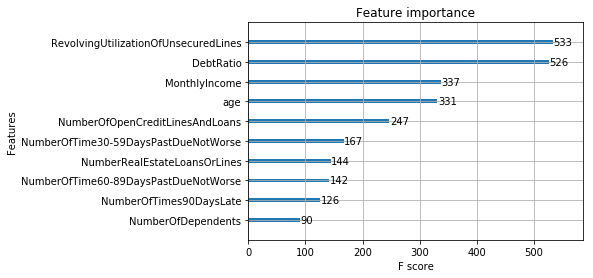

In [151]:
# final clf
clf = xgb.XGBClassifier(
    colsample_bytree=0.6,
    learning_rate=0.1,
    max_depth=5,
    min_child_weight=11,
    n_estimators=1000,
    objective='binary:logistic',
    subsample=0.7
)
modelfit(clf, X_train, y_train, X_test, y_test)

In [152]:
clf

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=11, missing=None, n_estimators=109,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.7)

In [153]:
sub1 = pd.DataFrame()
sub1['Probability'] = clf.predict_proba(test)[:,1]
sub1.insert(0, 'id', range(1, 1+len(sub1)))
sub1.head()

,id,Probability
0,1,0.066790
1,2,0.052954
2,3,0.015217
3,4,0.066142
4,5,0.101882


In [154]:
sub1.to_csv('submission2.csv', index=False)

The submission score a .8671 on private LB. 

## Part 1

Model interpretability: What is the effect of MonthlyIncome to the prediction? Quantify as much as you can how 1000, 2000 or 3000 extra per month affect the probability of delinquency. Do this by fitting a simple model on the dataset and using your best model.

In [62]:
# read in data
train = pd.read_csv("cs-training.csv")

# drop id
train = train.drop('Unnamed: 0', axis=1)

# fill missing values with 0
train = train.fillna(0)

# add 3000 to monthly income 
train_3000 = train.copy()
train_3000['MonthlyIncome'] += 3000 * train_3000['SeriousDlqin2yrs']

# split to X y
X_train = train.drop('SeriousDlqin2yrs', axis=1)
y_train = train['SeriousDlqin2yrs']
X_train3000 = train_3000.drop('SeriousDlqin2yrs', axis=1)

# log
X_train = np.log1p(X_train)
X_train3000 = np.log1p(X_train3000)

X_train.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0.568789,3.828641,1.098612,0.589442,9.118335,2.639057,0.000000,1.945910,0.0,1.098612
1,0.671490,3.713572,0.000000,0.115002,7.863651,1.609438,0.000000,0.000000,0.0,0.693147
2,0.505721,3.663562,0.693147,0.081684,8.020599,1.098612,0.693147,0.000000,0.0,0.000000
3,0.210107,3.433987,0.000000,0.035415,8.101981,1.791759,0.000000,0.000000,0.0,0.000000
4,0.645657,3.912023,0.693147,0.024620,11.060196,2.079442,0.000000,0.693147,0.0,0.000000


In [52]:
from sklearn.feature_selection import SelectFromModel
lr = LogisticRegression().fit(X_train, y_train)
lr3000 = LogisticRegression().fit(X_train3000, y_train)

sfm = SelectFromModel(lr, prefit=True)
sfm3000 = SelectFromModel(lr3000, prefit=True)

print 'Original:'
print lr.coef_
print sfm.get_support()
print 'Adding $3000:'
print lr3000.coef_
print sfm3000.get_support()

Original:
[[ 0.53156272 -1.07325208  1.14402473  0.05021117  0.04378993 -0.05302794
   1.46767914  0.00459053  0.66385476  0.15230493]]
[ True  True  True False False False  True False  True False]
Adding $3000:
[[ 0.48602366 -1.8401808   1.17645854  1.84369016  1.92135964 -0.50635672
   1.44147247 -0.83963895  0.79701426 -0.17587696]]
[False  True  True  True  True False  True False False False]


From the logistic regression coef, the increse in 'MonthlyIncome' dramatically increased the coefs of 'DebtRatio' and 'MonthlyIncome', which could mean that these two variables have a close relation.

Before adding $3000 to 'MonthlyIncome', the most importance features determined by Logistic Regression are: <br>
<ul>
    <li>RevolvingUtilizationOfUnsecuredLines
    <li>age
    <li>NumberOfTime30-59DaysPastDueNotWorse
    <li>NumberOfTimes90DaysLate
    <li>NumberOfTime60-89DaysPastDueNotWorse
</ul>
After, the new features are: <br>
<ul>
    <li>age
    <li>NumberOfTime30-59DaysPastDueNotWorse
    <li>DebtRatio
    <li>MonthlyIncome
    <li>NumberOfTimes90DaysLate
</ul>

In [63]:
# use xgb model to check the feature importance
clf = xgb.XGBClassifier(
    colsample_bytree=0.6,
    learning_rate=0.1,
    max_depth=5,
    min_child_weight=11,
    n_estimators=95,
    objective='binary:logistic',
    subsample=0.7
)

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train, test_size=.15)
X_train3000, X_test3000, y_train3000, y_test3000 = train_test_split(X_train3000, y_train, test_size=0.15)


Model Report
Accuracy : 0.9401
AUC Score (Train): 0.876524


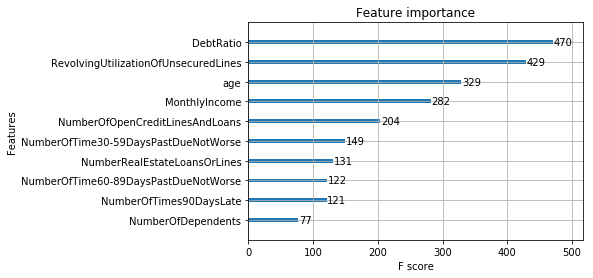

In [64]:
modelfit(clf, X_train1, y_train1, X_train1, y_train1)


Model Report
Accuracy : 0.9609
AUC Score (Train): 0.960396


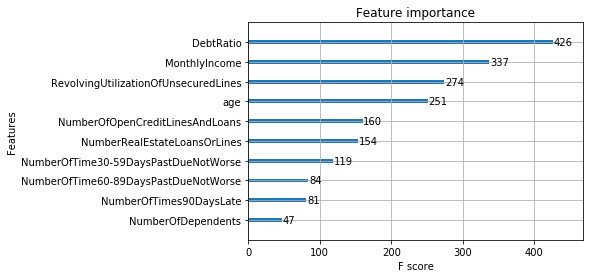

In [65]:
modelfit(clf, X_train3000, y_train3000, X_train3000, y_train3000)

The increase in 'MonthlyIncome' increase its F score while other other features stayed the same. XGBoost model did agree with Logistic Regression model in some ways, where both indicated 'MontlyIncome', 'DebtRatio', and 'age' as important features in datasets with a $3000 increase.

From the two models, I predict that 'MonthlyIncome' is an important feature for predicting the delinquency.

## Part 2

What is the most important variable in predicting delinquency? What is the most important pair of variables? Make a data science argument supported by data.

The most important variable in predicting delinquency is DebtRatio, from the XGBoost feature importance graph.

The most important pair are 'MonthlyIncome' and 'DebtRatio'. The reason is that from the $3000 increase in 'MonthlyIncome', I saw a big increase in the feature importance of 'MonthlyIncome' and 'DebtRatio'.
The XGBoost feature importance graph also supports the change.

# Part 3

The Age Discrimination in Employment Act (ADEA) forbids age discrimination against people who are age 40 or older. Does your good model (from part 0 above) discriminate against older people? Make the best argument you can.

In [76]:
# read in data
train = pd.read_csv("cs-training.csv")

# drop id
train = train.drop('Unnamed: 0', axis=1)

# fill missing values with 0
train = train.fillna(0)

young_train = train[train['age']<40]
old_train = train[train['age']>=40]

In [77]:
young_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
SeriousDlqin2yrs,32004.0,0.105299,0.306944,0.0,0.000000,0.000000,0.000000,1.0
RevolvingUtilizationOfUnsecuredLines,32004.0,7.870040,253.108801,0.0,0.072848,0.352177,0.876149,22198.0
age,32004.0,32.488814,4.708365,0.0,29.000000,33.000000,37.000000,39.0
NumberOfTime30-59DaysPastDueNotWorse,32004.0,0.837958,7.477345,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,32004.0,196.264406,1443.113102,0.0,0.132654,0.312237,0.644331,220516.0
MonthlyIncome,32004.0,4149.188383,4733.247505,0.0,1601.000000,3500.000000,5700.000000,251608.0
NumberOfOpenCreditLinesAndLoans,32004.0,6.463130,4.205757,0.0,3.000000,6.000000,9.000000,48.0
NumberOfTimes90DaysLate,32004.0,0.717379,7.481032,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,32004.0,0.666979,0.963488,0.0,0.000000,0.000000,1.000000,21.0
NumberOfTime60-89DaysPastDueNotWorse,32004.0,0.663761,7.469378,0.0,0.000000,0.000000,0.000000,98.0


In [78]:
old_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
SeriousDlqin2yrs,117996.0,0.056409,0.230710,0.0,0.000000,0.000000,0.00000,1.0
RevolvingUtilizationOfUnsecuredLines,117996.0,5.554366,248.836815,0.0,0.025241,0.121424,0.46821,50708.0
age,117996.0,57.667285,11.666981,40.0,48.000000,56.000000,65.00000,109.0
NumberOfTime30-59DaysPastDueNotWorse,117996.0,0.307951,2.668950,0.0,0.000000,0.000000,0.00000,98.0
DebtRatio,117996.0,395.517774,2169.270838,0.0,0.189549,0.380595,1.00000,329664.0
MonthlyIncome,117996.0,5673.329715,14605.524417,0.0,1500.000000,4700.000000,7900.00000,3008750.0
NumberOfOpenCreditLinesAndLoans,117996.0,8.992407,5.244122,0.0,5.000000,8.000000,12.00000,58.0
NumberOfTimes90DaysLate,117996.0,0.143539,2.616953,0.0,0.000000,0.000000,0.00000,98.0
NumberRealEstateLoansOrLines,117996.0,1.113512,1.152500,0.0,0.000000,1.000000,2.00000,54.0
NumberOfTime60-89DaysPastDueNotWorse,117996.0,0.125555,2.598977,0.0,0.000000,0.000000,0.00000,98.0


In [82]:
# split to X y
X_young = young_train.drop('SeriousDlqin2yrs', axis=1)
y_young = young_train['SeriousDlqin2yrs']
X_old, X_oldt, y_old, y_oldt = train_test_split(
    old_train.drop('SeriousDlqin2yrs', axis=1),
    old_train['SeriousDlqin2yrs'],
    test_size=.73
)

print X_young.shape, X_old.shape

# log
X_young = np.log1p(X_young)
X_old = np.log1p(X_old)

 (32004, 10) (31858, 10)


In [80]:
clf = xgb.XGBClassifier(
    colsample_bytree=0.6,
    learning_rate=0.1,
    max_depth=5,
    min_child_weight=11,
    n_estimators=95,
    objective='binary:logistic',
    subsample=0.7
)

In [83]:
print 'Young people: ', cross_val_score(estimator=clf, X=X_young, y=y_young, cv=5, scoring='roc_auc', n_jobs=3).mean()
print 'Old people: ', cross_val_score(estimator=clf, X=X_old, y=y_old, cv=5, scoring='roc_auc', n_jobs=3).mean()

Young people:  0.836853048292
Old people:  0.861163860723



Model Report
Accuracy : 0.9088
AUC Score (Train): 0.862857


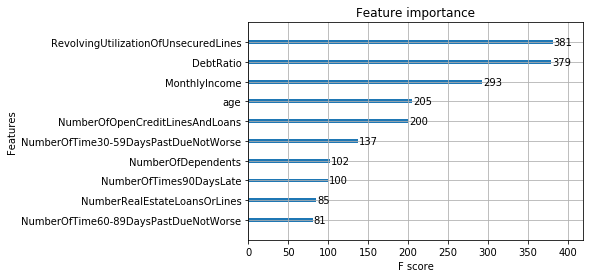

In [84]:
modelfit(clf, X_young, y_young, X_young, y_young)


Model Report
Accuracy : 0.9485
AUC Score (Train): 0.876807


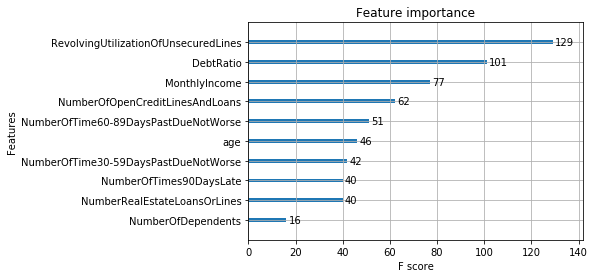

In [86]:
modelfit(clf, X_old, y_old, X_old, y_old)

I believe the model does not discreminate against old people, but 'age' is a feature that have an impact on prediction. 

From the dataset, there are 3 times more people who are over 40 than people who are under 40. Running cross validation on the two group with almost equal amount of data, the scores show that our model performs better on people who are
over 40.

From the feature importance graphs, there are changes to features' ranking, which is understandable as certain 
features become more important than others in different age group. 

# Part 4

Your manager asks if the number of dependents in the family (spouse, no of children) has an effect on loan delinquency. What do the data say? Calculate a p-value to express how confident you are.

In [130]:
# read in data
train = pd.read_csv("cs-training.csv")

# drop id
train = train.drop('Unnamed: 0', axis=1)

# fill missing values with 0
train = train.fillna(0)

X = train[['NumberOfDependents', 'SeriousDlqin2yrs']]
y = train['SeriousDlqin2yrs']